In [51]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import os, sys
# asumiendo que iris.ipynb está en notebooks/, y somJ/ en la carpeta superior:
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
from somJ.som       import *
import somJ.config  as config
from somJ.clustering import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [52]:
iris=load_iris()
data=iris.data
y_true=iris.target
n_clusters = np.unique(y_true).size
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data)

In [53]:
som = SoM(
    #method='pca',
    input_dim=data.shape[1],
    data=X_scaled,
    total_nodes=config.TOTAL_NODES
)


Dimensiones del SOM: m = 51, n = 19


In [54]:
som.train(
    train_data=X_scaled,
    learn_rate=config.LEARNING_RATE,
    radius_sq=config.RADIUS_SQ,
    lr_decay=config.LR_DECAY,
    radius_decay=config.RADIUS_DECAY,
    epochs=config.EPOCHS,
    update="online",
    batch_size=config.BATCH_SIZE,
    step=config.STEP,
    save=config.SAVE_HISTORY
)



array([[[0.47956285, 0.46090006, 0.53220847, 0.46349378],
        [0.49838131, 0.48098209, 0.5184185 , 0.6966591 ],
        [0.78725641, 0.39663536, 0.72271823, 0.61099005],
        ...,
        [0.22543667, 0.36120881, 0.78539097, 0.19163547],
        [0.81156279, 0.10906026, 0.9585675 , 0.4852281 ],
        [0.97113062, 0.60236239, 0.73854797, 0.04606964]],

       [[0.41282085, 0.27411179, 0.47528916, 0.37893392],
        [0.54733817, 0.37040399, 0.55013587, 0.52954865],
        [0.65576237, 0.4122297 , 0.66041133, 0.63115129],
        ...,
        [0.57567043, 0.34537585, 0.56238063, 0.80564266],
        [0.67012046, 0.59053687, 0.27083391, 0.87868414],
        [0.69629156, 0.9650187 , 0.17545153, 0.8642396 ]],

       [[0.49527309, 0.39611713, 0.50102111, 0.54162939],
        [0.65380699, 0.43903542, 0.62598491, 0.58178192],
        [0.66892295, 0.4207004 , 0.66983966, 0.65263563],
        ...,
        [0.35635589, 0.33897987, 0.65059533, 0.79124116],
        [0.48592625, 0.584661

In [55]:
bmu_coords = np.array([som.find_winner(x) for x in X_scaled])

Dimensiones del SOM: m = 51, n = 19


/tmp/ipykernel_445310/11739128.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_clusters)


Dimensiones del SOM: m = 51, n = 19


/tmp/ipykernel_445310/11739128.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_clusters)


Dimensiones del SOM: m = 51, n = 19


/tmp/ipykernel_445310/11739128.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_clusters)


Dimensiones del SOM: m = 51, n = 19


/tmp/ipykernel_445310/11739128.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_clusters)


Dimensiones del SOM: m = 51, n = 19


/tmp/ipykernel_445310/11739128.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_clusters)


Dimensiones del SOM: m = 51, n = 19


/tmp/ipykernel_445310/11739128.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_clusters)


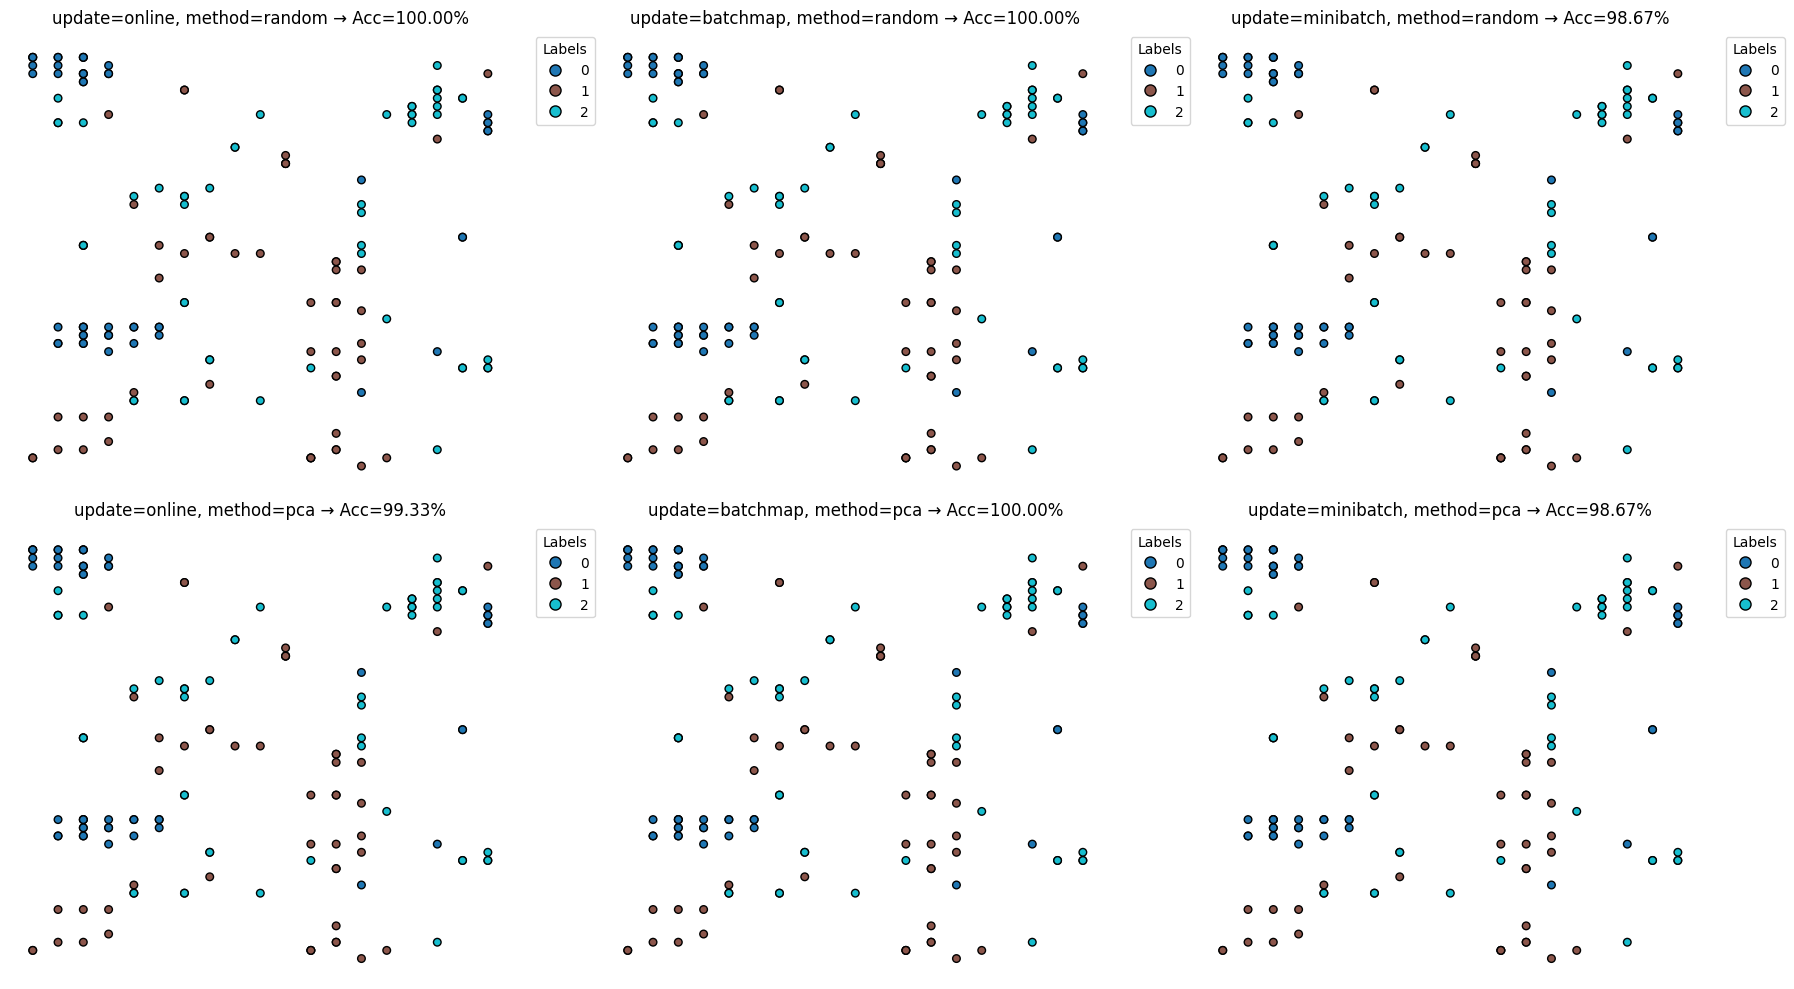

In [56]:
import numpy as np
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt

# Parámetros y configuraciones
updates = ["online", "batchmap", "minibatch"]
methods_order = ["random", "pca"]  # fila 0 → random; fila 1 → pca

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
n_clusters = 3  # Asegúrate de definir el número de clusters
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data)

for row, mtd in enumerate(methods_order):
    for col, upd in enumerate(updates):
        ax = axes[row, col]

        # 1) Entrena el SOM con esta combinación
        som = SoM(
            method=mtd,
            input_dim=data.shape[1],
            data=data,
            total_nodes=config.TOTAL_NODES
        )
        som.train(
            train_data=data,
            learn_rate=config.LEARNING_RATE,
            radius_sq=config.RADIUS_SQ,
            lr_decay=config.LR_DECAY,
            radius_decay=config.RADIUS_DECAY,
            epochs=config.EPOCHS,
            update=upd,
            batch_size=config.BATCH_SIZE,
            step=config.STEP,
            save=config.SAVE_HISTORY
        )

        y_pred = som.predict(data,y_true)
        acc = accuracy_score(y_true, y_pred)

        # 7) Dibuja en el subplot: fondo + scatter de BMUs + leyenda
        cmap = plt.cm.get_cmap('tab10', n_clusters)
        ax.axis("off")
        ax.set_title(f"update={upd}, method={mtd} → Acc={acc:.2%}", pad=10)

        # Superponer puntos BMU con color de etiqueta verdadera
        xs = bmu_coords[:, 1]
        ys = bmu_coords[:, 0]
        scatter = ax.scatter(xs, ys, c=y_true, cmap=cmap, s=30, edgecolor='k')

        # Añadir leyenda de etiquetas
        unique_labels = np.unique(y_true)
        handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(lbl),
                              markerfacecolor=cmap(lbl), markersize=8, markeredgecolor='k')
                   for lbl in unique_labels]
        ax.legend(handles=handles, title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Ajuste y muestra
plt.tight_layout()
plt.show()

Precisión SOM (MiniSom): 1.00


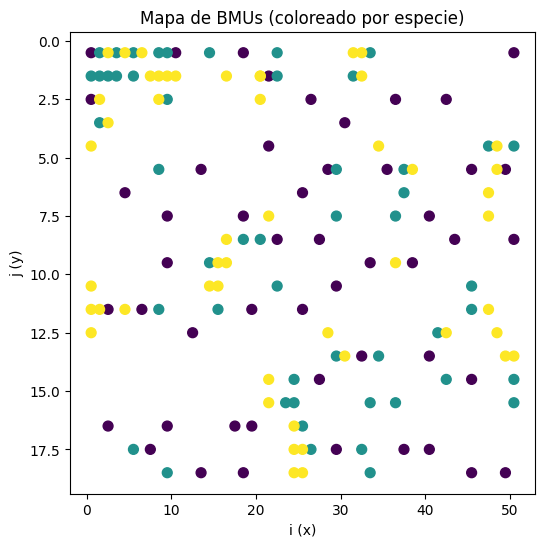

In [ ]:
from minisom import MiniSom
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# Carga y escala el dataset
iris = load_iris()
X = iris.data
y = iris.target
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

som = MiniSom(x=51, y=19, input_len=4, sigma=config.RADIUS_SQ, learning_rate=config.LEARNING_RATE,
              neighborhood_function='gaussian', random_seed=42)
som.random_weights_init(X_scaled)

# Entrena el SOM
som.train_random(data=X_scaled, num_iteration=config.EPOCHS)

# Etiqueta cada unidad con la mayoría de votos
labels_map = {}
for xi, label in zip(X_scaled, y):
    w = som.winner(xi)             # índice (i,j) de la BMU
    labels_map.setdefault(w, []).append(label)

# toma la etiqueta más frecuente por nodo
labels_map = {pos: np.bincount(lbls).argmax() 
              for pos, lbls in labels_map.items()}

# Predicción y precisión
y_pred = np.array([labels_map[som.winner(xi)] for xi in X_scaled])
accuracy = np.mean(y_pred == y)
print(f"Precisión SOM (MiniSom): {accuracy:.2f}")

# Visualización de los BMU en el grid
coords = np.array([som.winner(xi) for xi in X_scaled])
plt.figure(figsize=(6,6))
plt.scatter(coords[:,0]+0.5, coords[:,1]+0.5, c=y, s=50, cmap='viridis')
plt.title('Mapa de BMUs (coloreado por especie)')

plt.gca().invert_yaxis()
plt.xlabel('i (x)')
plt.ylabel('j (y)')
plt.show()
